#### Dataset Analysis and Network Construction

##### Load and Inspect Datasets

In [37]:
# Import necessary libraries
import pandas as pd
import networkx as nx
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Function to load datasets with error handling
def load_dataset(file_path, column_names):
    try:
        # Load dataset
        data = pd.read_csv(file_path, header=None)
        data.columns = column_names
        return data
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        raise
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty or corrupted.")
        raise
    except Exception as e:
        print(f"An unexpected error occurred while loading '{file_path}': {e}")
        raise

# Define column names for datasets
airport_columns = [
    'Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO',
    'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST',
    'Tz Database Timezone', 'Type', 'Source'
]

route_columns = [
    'Airline', 'Airline ID', 'Source', 'Source ID', 'Destination',
    'Destination ID', 'Codeshare', 'Stops', 'Equipment'
]

# Load datasets
airports = load_dataset('airports.dat', airport_columns)
routes = load_dataset('routes.dat', route_columns)

# Inspect datasets
print("Airports Data (First 5 Rows):")
print(airports.head())
print("\nRoutes Data (First 5 Rows):")
print(routes.head())


Airports Data (First 5 Rows):
   Airport ID                                         Name          City  \
0           1                               Goroka Airport        Goroka   
1           2                               Madang Airport        Madang   
2           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3           4                               Nadzab Airport        Nadzab   
4           5  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  ICAO  Latitude   Longitude  Altitude Timezone DST  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998      5282       10   U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001        20       10   U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005      5388       10   U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977       239       10   U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001       146       10   U   

   Tz Database Timezone     Type      

##### Dataset Cleaning and Sanity Checks

In [38]:
# Function to clean datasets
def clean_dataset(data, subset_columns, description):
    initial_rows = len(data)
    data = data.dropna(subset=subset_columns)
    rows_after_na_removal = len(data)
    print(f"{description}: Removed {initial_rows - rows_after_na_removal} rows with missing values.")

    data = data.drop_duplicates()
    rows_after_deduplication = len(data)
    print(f"{description}: Removed {rows_after_na_removal - rows_after_deduplication} duplicate rows.")

    return data

# Function to handle duplicate IATA codes
def handle_duplicate_iata(data):
    duplicates = data[data.duplicated(subset=['IATA'], keep=False)]
    if not duplicates.empty:
        print("\nDuplicate IATA Codes:")
        print(duplicates)

    data = data.drop_duplicates(subset=['IATA'], keep='first')
    print(f"Removed {len(duplicates) // 2} duplicate IATA entries, keeping the first occurrence.")

    return data

# Clean the datasets
airports = clean_dataset(airports, ['IATA', 'Latitude', 'Longitude'], "Airports Dataset")
routes = clean_dataset(routes, ['Source', 'Destination'], "Routes Dataset")

# Handle duplicate IATA codes in airports dataset
airports = handle_duplicate_iata(airports)

# Verify cleaned datasets
print("\nCleaned Airports Data (First 5 Rows):")
print(airports.head())
print("\nCleaned Routes Data (First 5 Rows):")
print(routes.head())


Airports Dataset: Removed 0 rows with missing values.
Airports Dataset: Removed 0 duplicate rows.
Routes Dataset: Removed 0 rows with missing values.
Routes Dataset: Removed 0 duplicate rows.

Duplicate IATA Codes:
      Airport ID                               Name          City  Country  \
21            22     Winnipeg / St. Andrews Airport      Winnipeg   Canada   
22            23  Halifax / CFB Shearwater Heliport       Halifax   Canada   
43            44                  Princeton Airport     Princeton   Canada   
103          104               Pitt Meadows Airport  Pitt Meadows   Canada   
210          212                   Boufarik Airport      Boufarik  Algeria   
...          ...                                ...           ...      ...   
7692       14105                   Kubinka Air Base       Kubinka   Russia   
7693       14106                Rogachyovo Air Base        Belaya   Russia   
7694       14107              Ulan-Ude East Airport      Ulan Ude   Russia   
7695 

##### Single-Layer Network Construction


Graph Statistics:
Number of nodes (airports): 6073
Number of edges (routes): 37042


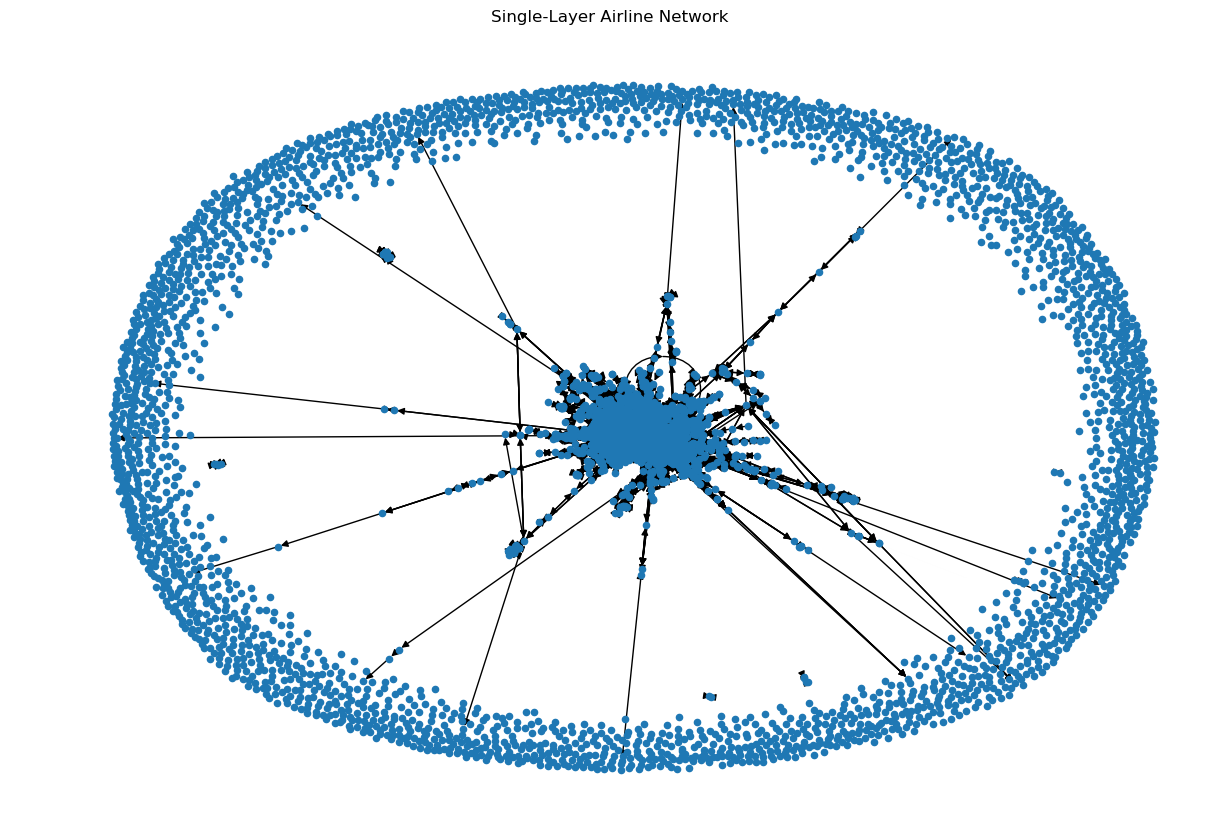

In [39]:
# Function to create airport coordinates dictionary
def create_airport_coords(data):
    if not data['IATA'].is_unique:
        raise ValueError("IATA codes must be unique for creating the coordinates dictionary.")
    return data.set_index('IATA')[['Latitude', 'Longitude']].to_dict('index')

# Function to construct a directed graph
def construct_graph(airports, routes, coords):
    G = nx.DiGraph()

    # Add nodes
    for _, row in airports.iterrows():
        G.add_node(row['IATA'], name=row['Name'], country=row['Country'])

    # Add edges
    valid_routes = routes[(routes['Source'].isin(coords)) & (routes['Destination'].isin(coords))]
    G.add_edges_from(zip(valid_routes['Source'], valid_routes['Destination']))

    return G

# Function to visualize the graph
def visualize_graph(graph, title="Graph Visualization"):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, seed=42)  # Consistent layout for reproducibility
    nx.draw(graph, pos, with_labels=False, node_size=20, font_size=8)
    plt.title(title)
    plt.show()

# Create airport coordinates dictionary
airport_coords = create_airport_coords(airports)

# Construct the directed graph
G = construct_graph(airports, routes, airport_coords)

# Print basic graph statistics
print("\nGraph Statistics:")
print(f"Number of nodes (airports): {G.number_of_nodes()}")
print(f"Number of edges (routes): {G.number_of_edges()}")

# Visualize the single-layer graph
visualize_graph(G, "Single-Layer Airline Network")


##### Weighted Edge Assignment

In [40]:
# Function to compute weights and assign them to graph edges
def assign_weights_to_edges(graph, coords):
    for source, target in graph.edges:
        source_coords = coords[source]
        target_coords = coords[target]

        # Compute geographic distance
        distance = geodesic(
            (source_coords['Latitude'], source_coords['Longitude']),
            (target_coords['Latitude'], target_coords['Longitude'])
        ).kilometers

        # Assign weight to the edge
        graph[source][target]['weight'] = distance

# Function to save the graph to a file
def save_graph(graph, file_name):
    try:
        nx.write_gml(graph, file_name)
        print(f"Graph successfully saved to {file_name}.")
    except Exception as e:
        print(f"Error saving graph to {file_name}: {e}")

# Function to print sample edges with weights
def print_sample_edges_with_weights(graph, sample_size=5):
    print("\nSample Edges with Weights:")
    for edge in list(graph.edges(data=True))[:sample_size]:
        print(edge)

# Assign weights to edges
assign_weights_to_edges(G, airport_coords)

# Save the graph
save_graph(G, 'single_layer_network.gml')

# Print sample edges with weights
print_sample_edges_with_weights(G)


Graph successfully saved to single_layer_network.gml.

Sample Edges with Weights:
('GKA', 'HGU', {'weight': 124.58232437170456})
('GKA', 'LAE', {'weight': 157.16009340927107})
('GKA', 'MAG', {'weight': 106.24895852093672})
('GKA', 'POM', {'weight': 422.931338047984})
('MAG', 'GKA', {'weight': 106.24895852093672})


##### Multilayer Network Construction

In [41]:
# Function to create a multilayer graph
def create_multilayer_graph(airports, routes, layers, coords):
    MLG = nx.MultiGraph()

    # Add nodes (airports remain the same across layers)
    for row in airports.itertuples():
        MLG.add_node(row.IATA, name=row.Name, country=row.Country)

    # Add edges for each layer
    for layer in layers:
        valid_routes = routes[(routes['Source'].isin(coords)) & (routes['Destination'].isin(coords))]
        MLG.add_edges_from(
            [(row.Source, row.Destination, {'layer': layer}) for row in valid_routes.itertuples()]
        )

    return MLG

# Function to display edges count by layer
def display_edges_by_layer(graph, layers):
    for layer in layers:
        edges_in_layer = [(u, v, d) for u, v, d in graph.edges(data=True) if d['layer'] == layer]
        print(f"Edges in {layer} layer: {len(edges_in_layer)}")

# Function to save the multilayer graph
def save_multilayer_graph(graph, file_name):
    try:
        nx.write_gml(graph, file_name)
        print(f"Multilayer graph successfully saved to {file_name}.")
    except Exception as e:
        print(f"Error saving multilayer graph to {file_name}: {e}")

# Define layers
layers = ['Passenger', 'Crew', 'Aircraft']

# Create the multilayer graph
MLG = create_multilayer_graph(airports, routes, layers, airport_coords)

# Display edges count by layer
display_edges_by_layer(MLG, layers)

# Save the multilayer graph
save_multilayer_graph(MLG, 'multilayer_network.gml')


Edges in Passenger layer: 66934
Edges in Crew layer: 66934
Edges in Aircraft layer: 66934
Multilayer graph successfully saved to multilayer_network.gml.


##### Calculate Robustness Metrics

In [42]:
# Function to calculate robustness metrics
def calculate_robustness(graph, layer_name, max_nodes=None):
    original_connected_components = nx.number_connected_components(graph)
    print(f"\n{layer_name} Layer - Initial Connected Components: {original_connected_components}")

    robustness_results = []
    nodes_to_process = list(graph.nodes)[:max_nodes] if max_nodes else list(graph.nodes)

    for node in nodes_to_process:
        graph_copy = graph.copy()
        graph_copy.remove_node(node)
        components = nx.number_connected_components(graph_copy)
        robustness_results.append((node, components))
        print(f"Removed {node}: Connected Components = {components}")

    return robustness_results

# Function to prepare a graph for robustness analysis
def prepare_layer_graph(multilayer_graph, layer_name):
    layer_edges = [(u, v) for u, v, d in multilayer_graph.edges(data=True) if d['layer'] == layer_name]
    layer_graph = nx.Graph()
    layer_graph.add_edges_from(layer_edges)
    return layer_graph

# Robustness analysis for each layer
for layer in ['Passenger', 'Crew', 'Aircraft']:
    layer_graph = prepare_layer_graph(MLG, layer)

    print(f"\nRobustness Analysis for {layer} Layer")
    robustness_results = calculate_robustness(layer_graph, layer, max_nodes=50)



Robustness Analysis for Passenger Layer

Passenger Layer - Initial Connected Components: 7
Removed GKA: Connected Components = 7
Removed HGU: Connected Components = 7
Removed LAE: Connected Components = 7
Removed MAG: Connected Components = 7
Removed POM: Connected Components = 11
Removed WWK: Connected Components = 7
Removed MAS: Connected Components = 7
Removed VAI: Connected Components = 7
Removed MXH: Connected Components = 7
Removed TBG: Connected Components = 7
Removed TIZ: Connected Components = 7
Removed UNG: Connected Components = 7
Removed DAU: Connected Components = 7
Removed HKN: Connected Components = 7
Removed PNP: Connected Components = 7
Removed RAB: Connected Components = 7
Removed BNE: Connected Components = 9
Removed GUR: Connected Components = 7
Removed BUL: Connected Components = 7
Removed BUA: Connected Components = 7
Removed CEB: Connected Components = 9
Removed CMU: Connected Components = 7
Removed CNS: Connected Components = 12
Removed DPS: Connected Component

##### Analyze Delay Propagation

In [43]:
# Function to simulate delay propagation and analyze the impact
def simulate_delay_propagation(ml_graph, failure_layer, num_edges_to_remove=10):
    print(f"\nSimulating failures in {failure_layer} layer and analyzing impact:")

    # Extract edges of the failure layer
    layer_edges = [(u, v) for u, v, d in ml_graph.edges(data=True) if d['layer'] == failure_layer]
    if len(layer_edges) < num_edges_to_remove:
        print(f"Warning: {failure_layer} layer has fewer than {num_edges_to_remove} edges. Removing all available edges.")
        num_edges_to_remove = len(layer_edges)

    # Remove a subset of edges
    removed_edges = layer_edges[:num_edges_to_remove]  # Example: remove the first `num_edges_to_remove` edges
    failure_graph = nx.Graph()
    failure_graph.add_edges_from(layer_edges)
    failure_graph.remove_edges_from(removed_edges)

    # Measure impact on other layers
    for layer in set(d['layer'] for _, _, d in ml_graph.edges(data=True)):
        if layer != failure_layer:
            other_layer_edges = [(u, v) for u, v, d in ml_graph.edges(data=True) if d['layer'] == layer]
            other_layer_graph = nx.Graph()
            other_layer_graph.add_edges_from(other_layer_edges)

            # Calculate connectivity after failure
            connected_components = nx.number_connected_components(other_layer_graph)
            print(f"After failures in {failure_layer}, {layer} Layer Connected Components: {connected_components}")

# Simulate delay propagation for each layer
for failure_layer in set(d['layer'] for _, _, d in MLG.edges(data=True)):
    simulate_delay_propagation(MLG, failure_layer, num_edges_to_remove=10)



Simulating failures in Aircraft layer and analyzing impact:
After failures in Aircraft, Passenger Layer Connected Components: 7
After failures in Aircraft, Crew Layer Connected Components: 7

Simulating failures in Passenger layer and analyzing impact:
After failures in Passenger, Aircraft Layer Connected Components: 7
After failures in Passenger, Crew Layer Connected Components: 7

Simulating failures in Crew layer and analyzing impact:
After failures in Crew, Aircraft Layer Connected Components: 7
After failures in Crew, Passenger Layer Connected Components: 7


##### Compare Relative Importance of Layers

In [44]:
# Function to calculate centrality metrics for a specific layer
def calculate_layer_centrality(graph, layer_name, top_n=5):
    # Filter edges for the specified layer
    layer_edges = [(u, v) for u, v, d in graph.edges(data=True) if d['layer'] == layer_name]
    if not layer_edges:
        print(f"No edges found for layer '{layer_name}'. Skipping centrality calculation.")
        return {}

    # Create an undirected graph for the layer
    layer_graph = nx.Graph()
    layer_graph.add_edges_from(layer_edges)

    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(layer_graph)
    betweenness_centrality = nx.betweenness_centrality(layer_graph)

    # Get top nodes by centrality
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Log results
    print(f"\nCentrality Metrics for {layer_name} Layer:")
    print("Top Nodes by Degree Centrality:")
    for node, centrality in top_degree:
        print(f"  Node: {node}, Centrality: {centrality:.4f}")

    print("Top Nodes by Betweenness Centrality:")
    for node, centrality in top_betweenness:
        print(f"  Node: {node}, Centrality: {centrality:.4f}")

    return {
        'degree_centrality': top_degree,
        'betweenness_centrality': top_betweenness
    }

# Compute centrality metrics for each layer dynamically
def compute_centrality_for_all_layers(graph, layers):
    results = {}
    for layer in layers:
        results[layer] = calculate_layer_centrality(graph, layer)
    return results

# Dynamically extract layers from the graph
layers = set(d['layer'] for _, _, d in MLG.edges(data=True))

# Compute centrality metrics for each layer
centrality_results = compute_centrality_for_all_layers(MLG, layers)



Centrality Metrics for Aircraft Layer:
Top Nodes by Degree Centrality:
  Node: AMS, Centrality: 0.0762
  Node: FRA, Centrality: 0.0749
  Node: CDG, Centrality: 0.0737
  Node: IST, Centrality: 0.0722
  Node: ATL, Centrality: 0.0666
Top Nodes by Betweenness Centrality:
  Node: CDG, Centrality: 0.0636
  Node: LAX, Centrality: 0.0598
  Node: ANC, Centrality: 0.0577
  Node: DXB, Centrality: 0.0564
  Node: FRA, Centrality: 0.0522

Centrality Metrics for Passenger Layer:
Top Nodes by Degree Centrality:
  Node: AMS, Centrality: 0.0762
  Node: FRA, Centrality: 0.0749
  Node: CDG, Centrality: 0.0737
  Node: IST, Centrality: 0.0722
  Node: ATL, Centrality: 0.0666
Top Nodes by Betweenness Centrality:
  Node: CDG, Centrality: 0.0636
  Node: LAX, Centrality: 0.0598
  Node: ANC, Centrality: 0.0577
  Node: DXB, Centrality: 0.0564
  Node: FRA, Centrality: 0.0522

Centrality Metrics for Crew Layer:
Top Nodes by Degree Centrality:
  Node: AMS, Centrality: 0.0762
  Node: FRA, Centrality: 0.0749
  Node: C

##### Visualize Results


Passenger Layer - Initial Connected Components: 7
Removed GKA: Connected Components = 7
Removed HGU: Connected Components = 7
Removed LAE: Connected Components = 7
Removed MAG: Connected Components = 7
Removed POM: Connected Components = 11
Removed WWK: Connected Components = 7
Removed MAS: Connected Components = 7
Removed VAI: Connected Components = 7
Removed MXH: Connected Components = 7
Removed TBG: Connected Components = 7
Removed TIZ: Connected Components = 7
Removed UNG: Connected Components = 7
Removed DAU: Connected Components = 7
Removed HKN: Connected Components = 7
Removed PNP: Connected Components = 7
Removed RAB: Connected Components = 7
Removed BNE: Connected Components = 9
Removed GUR: Connected Components = 7
Removed BUL: Connected Components = 7
Removed BUA: Connected Components = 7
Removed CEB: Connected Components = 9
Removed CMU: Connected Components = 7
Removed CNS: Connected Components = 12
Removed DPS: Connected Components = 8
Removed HIR: Connected Components =

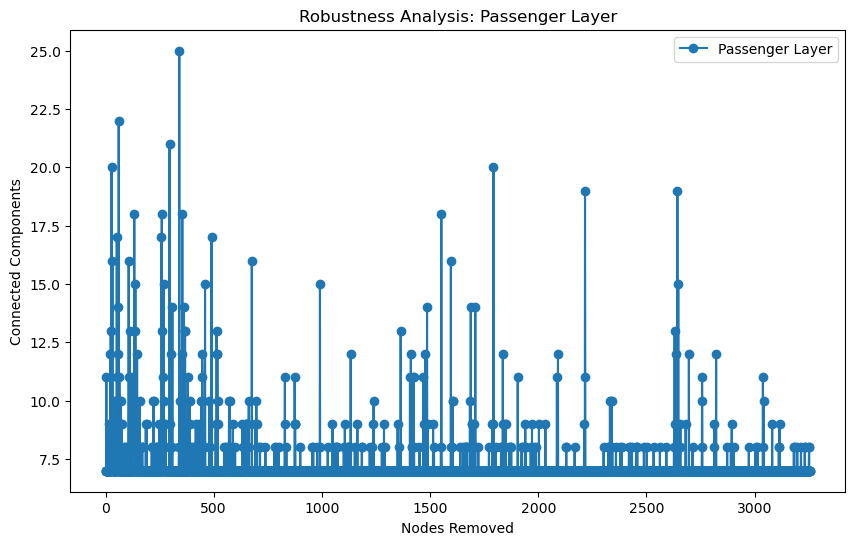

In [47]:
# Visualize delay propagation impact
def visualize_impact(layer_name, robustness_results):
    nodes = [result[0] for result in robustness_results]
    components = [result[1] for result in robustness_results]

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(nodes)), components, marker='o', label=f'{layer_name} Layer')
    plt.title(f'Robustness Analysis: {layer_name} Layer')
    plt.xlabel('Nodes Removed')
    plt.ylabel('Connected Components')
    plt.legend()
    plt.show()

# Example: Visualizing robustness results for Passenger layer
robustness_results_passenger = calculate_robustness(layer_graph, 'Passenger')
visualize_impact('Passenger', robustness_results_passenger)


In [46]:
# Save cleaned datasets to CSV files
airports.to_csv('cleaned_airports.csv', index=False)
routes.to_csv('cleaned_routes.csv', index=False)
